In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack


# Just for in this notebook
import sys
sys.path.append('../assignment1/to_hand_in/')

import some_routines as sr
from tqdm import tqdm_notebook as tqdm

# 5. Mass assignment schemes

#### $S(x)$ is the mass density at the distance $x$ from the particle for cell size $\Delta x$. We use periodic boundary conditions. 

#### a). The most simple choice for the particle shape is a point-like shape given by
\begin{equation}
S(x) = \frac{1}{\Delta x} \delta(\frac{x}{\Delta x})
\end{equation}
#### Explain how we need to assign mass in this scheme and explain why this method is called the NGP method. Code up this method yourself, display slices

The fraction of a particle's mass assigned to it's nearest cell $ijk$ is the integral of the shape function over this cell:
\begin{equation}
W_x = \int_{x_{ijk} - \Delta x /2}^{x_{ijk} - \Delta x /2} S(x_p - x') dx'
\end{equation}
which is equivalent for the $y$ and $z$ directions. The product of the three directions is then the fraction of mass $W$. Thus the mass in a cell is in this case given as the mass of the particles that are in the cell
\begin{equation}
M_{ijk} = \sum_{p=1}^{N_p} m_p W(\vec{r}_p - \vec{r}_{ijk}) 
\end{equation}
In our implementation we simply loop over all particles once and assign their mass to the nearest cell point. 

Reference: http://background.uchicago.edu/~whu/Courses/Ast321_11/pm.pdf

In [67]:
class NGP(object):
    def __init__(self, nperdim, positions):
        """
        nperdim   -- int: amount of points per dimension
        positions -- array: 3D positions of the particles (3,?)
        """
        self.nperdim = nperdim
        # Particle positions [xvalues,yvalues,zvalues]
        self.positions = positions
        # 1D grid positions
        self.onedim = sr.linspace(0,nperdim, nperdim+1)
        # 3D Grid positions, shape (3,nperdim,nperdim,nperdim)
        self.grid = np.meshgrid(self.onedim,self.onedim,self.onedim)
        # cell size
        self.deltax = 1
        # Masses of the gridpoints
        self.massgrid = self.assign_mass()
        
    def assign_mass(self):
        massgrid = np.zeros((self.nperdim,self.nperdim,self.nperdim))
        # Index of the cell containing the particle is floored int
        indices = np.array(self.positions, dtype='int')
        # Assign each particle mass to its nearest gridpoint
        for i in range(indices.shape[1]):
            massgrid[tuple(indices[:,i])] += 1
        return massgrid

In [95]:
# Particle positions
np.random.seed(121)
positions = np.random.uniform(low=0,high=16,size=(3,1024))

In [96]:
ngp = NGP(16,positions)

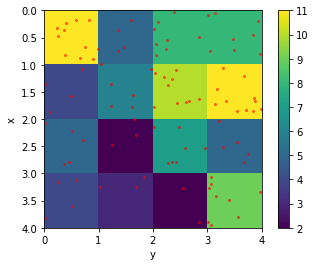

11 11.0
11 11.0


In [128]:
# TEST cell
# postest = np.random.uniform(low=0,high=4,size=(3,100))
# ngptest = NGP(4,postest)

# Remember that x is the first axis and y is the second, so switch
plt.scatter(postest[1],postest[0],s=4,c='r',alpha=0.5)
plt.imshow(np.sum(ngptest.massgrid,axis=2),extent=[0,4,4,0])
plt.colorbar()
plt.xlabel('y')
plt.ylabel('x')
plt.savefig('./test.pdf')
plt.show()

print (np.sum((postest[0] < 1) & (postest[1]<1) )
       ,np.sum(ngptest.massgrid[0,0]))
print (np.sum((postest[0] > 1) & (postest[1]>3) 
             &(postest[0] < 2) & (postest[1]<4))
       ,np.sum(ngptest.massgrid[1,3]))

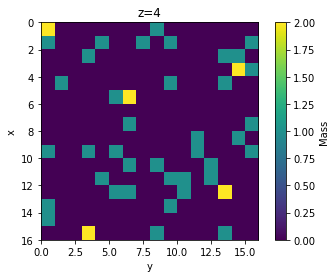

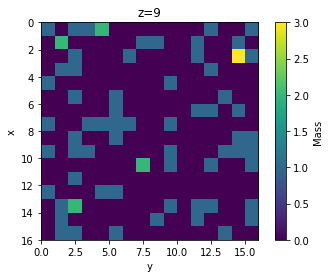

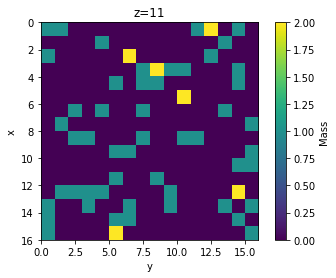

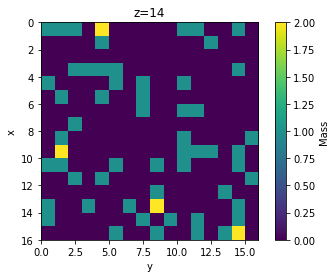

In [138]:
for z in [4,9,11,14]:
    plt.title(f"z={z}")
    # Fix the imshow axes with extent
    plt.imshow(ngp.massgrid[:,:,z],extent=[0,16,16,0])
    cbar = plt.colorbar()
    cbar.set_label('Mass')
    # remember switch x and y in arrays
    plt.xlabel('y')
    plt.ylabel('x')
#     plt.savefig('./test.pdf')
    plt.show()

#### b) To check the robustness of your implementation make a plot of the $x$ position of an individual particle and the value in cell 4 in 1 dimension. Let $x$ vary from the lowest value to the highest possible value in $x$. Repeat for cell 0

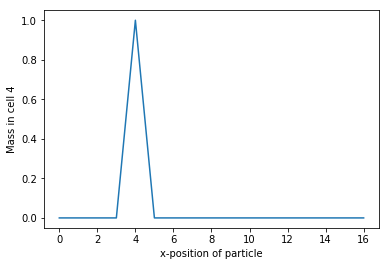

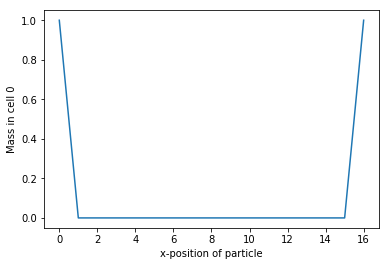

In [66]:
all_x = sr.linspace(0,16,17)
cell4 = []
cell0 = []
for x in all_x:
    x = x%16 # periodic boundary conditions
    testpos = np.array([x,0,0])[:,np.newaxis] 
    ngp = NGP(16,testpos)
    cell4.append(ngp.massgrid[4,0,0])
    cell0.append(ngp.massgrid[0,0,0])
    
plt.plot(all_x,cell4)
plt.ylabel('Mass in cell 4')
plt.xlabel('x-position of particle')
plt.show()

plt.plot(all_x,cell0)
plt.ylabel('Mass in cell 0')
plt.xlabel('x-position of particle')
plt.show()

#### c) Now use method that assumes particles are 3D cubes of uniform density and have the size of a grid cell. This means the particle shape is given by ..

#### Calculate how mass needs to be assigned in this case (Cloud in Cell method and implement it in code. To check the robustness make the same plots as before (in a and b)

For CIC, the particle can contribute to the cell it is currently in and the seven (in 3D) other neighbouring cells. We can define $dx = x_p - x_c$ as the distance between the particle and the cell, and $t_x = 1-d_x$. Then the contributions of mass to each of the eight cells are linear interpolations, coded up below.

In [74]:
class CIC(object):
    def __init__(self, nperdim, positions):
        """
        nperdim   -- int: amount of gridpoints per dimension
        positions -- array: 3D positions of the particles (3,?)
        """
        self.nperdim = nperdim
        # Particle positions [xvalues,yvalues,zvalues]
        self.positions = positions
        # 1D grid positions
        self.onedim = sr.linspace(0,nperdim, nperdim+1)
        # 3D Grid positions, shape (3,nperdim,nperdim,nperdim)
        self.grid = np.meshgrid(self.onedim,self.onedim,self.onedim)
        # cell size
        self.deltax = 1
        # Masses of the gridpoints
        self.massgrid = self.assign_mass()
        
    def assign_mass(self):
        massgrid = np.zeros((self.nperdim,self.nperdim,self.nperdim))
        # Index of the cell containing the particle is floored int
        indices = np.array(self.positions, dtype='int')
        # Distances to nearest grid point
        dr = self.positions-indices
        tr = 1-dr
        
        # Assign each particle mass to 8 gridpoints
        for i in range(indices.shape[1]):
            indx = indices[:,i]
            # Current cell
            massgrid[tuple(indx)] += np.prod(tr[:,i])
            # Neighbours. Note periodic boundary conditions
            idx = tuple((indx+np.array([1,0,0]))%self.nperdim)
            massgrid[idx] += dr[0,i]*tr[1,i]*tr[2,i]
            idx = tuple((indx+np.array([0,1,0]))%self.nperdim)
            massgrid[idx] += tr[0,i]*dr[1,i]*tr[2,i]
            idx = tuple((indx+np.array([1,1,0]))%self.nperdim)
            massgrid[idx] += dr[0,i]*dr[1,i]*tr[2,i]
            idx = tuple((indx+np.array([0,0,1]))%self.nperdim)
            massgrid[idx] += tr[0,i]*tr[1,i]*dr[2,i]
            idx = tuple((indx+np.array([1,0,1]))%self.nperdim)
            massgrid[idx] += dr[0,i]*tr[1,i]*dr[2,i]
            idx = tuple((indx+np.array([0,1,1]))%self.nperdim)
            massgrid[idx] += tr[0,i]*dr[1,i]*dr[2,i]
            idx = tuple((indx+np.array([1,1,1]))%self.nperdim)
            massgrid[idx] += dr[0,i]*dr[1,i]*dr[2,i]
        return massgrid

In [75]:
cic = CIC(16,positions)

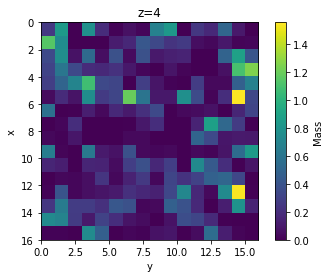

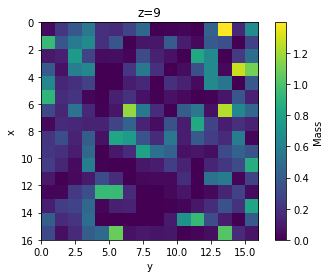

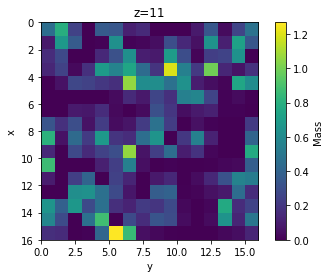

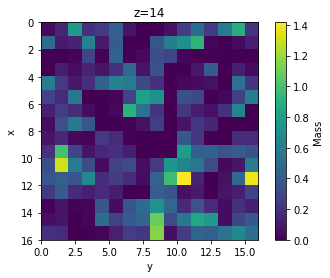

In [139]:
for z in [4,9,11,14]:
    plt.title(f"z={z}")
    plt.imshow(cic.massgrid[:,:,z],extent=[0,16,16,0])
    cbar = plt.colorbar()
    cbar.set_label('Mass')
    plt.xlabel('y')
    plt.ylabel('x')
#     plt.savefig('./test.pdf')
    plt.show()

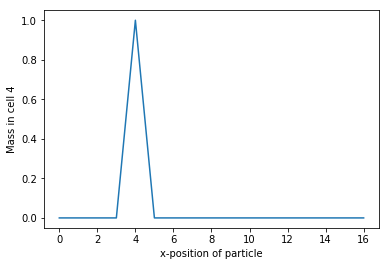

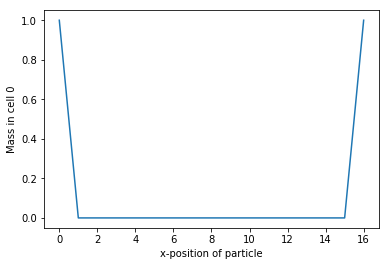

In [77]:
all_x = sr.linspace(0,16,17)
cell4 = []
cell0 = []
for x in all_x:
    x = x%16 # periodic boundary conditions
    testpos = np.array([x,0,0])[:,np.newaxis] 
    cic = CIC(16,testpos)
    cell4.append(cic.massgrid[4,0,0])
    cell0.append(cic.massgrid[0,0,0])
    
plt.plot(all_x,cell4)
plt.ylabel('Mass in cell 4')
plt.xlabel('x-position of particle')
plt.show()

plt.plot(all_x,cell0)
plt.ylabel('Mass in cell 0')
plt.xlabel('x-position of particle')
plt.show()

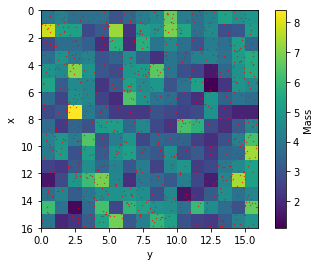

In [152]:
# TEST CELL
cic = CIC(16,positions)
plt.scatter(positions[1],positions[0],c='r',s=0.1)
plt.imshow(np.sum(cic.massgrid[:,:,:],axis=2),extent=[0,16,16,0])
cbar = plt.colorbar()
cbar.set_label('Mass')
# remember switch x and y axis
plt.xlabel('y')
plt.ylabel('x')
plt.savefig('./test2.pdf')
plt.show()

#### d) Write your own FFT algorithm, check that your code works with a 1D function (no Gaussian) by making a plot of the FFT and compare your result with a python package and the analytical FFT of your function. For the rest of the exercise use your own FFT

In [247]:
def FFT1D(x):
    """
    Perform the FFT of input array x using the Cooley-Tukey algorithm
    """
    N = len(x)
    assert N%2 == 0 or N==1, "N should be a power of 2"
        
    if N > 1:
        # split in even and odd elements
        ffteven = FFT1D(x[0::2])
        fftodd = FFT1D(x[1::2])
        
        fft = np.zeros(N,dtype=np.complex)
        # Exploit the period in k
        for k in range(0,N//2):
            t = ffteven[k]
            W = np.exp(-2j*np.pi*k/N)
            
            fft[k] = t + W*fftodd[k]
            fft[k+N//2] = t - W*fftodd[k]
            
        return fft
    else:
        return x
        
def FFT1D(x):
    """
    Perform the FFT of input array x using the Cooley-Tukey algorithm
    """
    N = len(x)
    if N > 1:
        # split in even and odd elements
        ffteven = FFT1D_tst(x[0::2])
        fftodd = FFT1D_tst(x[1::2])
        
        # Exploit the period in k, vectorize instead of loop
        k = sr.linspace(0,N//2-1,N//2)
        W = np.exp(-2j*np.pi*k/N)*fftodd
        return np.concatenate([ffteven + W
                       , ffteven-W])
    else:
        return x
        

In [248]:
def function(x):
    return 2*x+np.sin(2*np.pi*x/5)+3*np.cos(2*np.pi*x/2)*np.sin(2*x)
    
def function(x):
    return 2*np.sin(2*np.pi*x)

x = np.array(np.linspace(0,20,64),dtype=np.complex_)
fx = function(x)
fk = FFT1D(fx)
fknp = np.fft.fft(fx)
fktst = FFT1D_tst(fx)

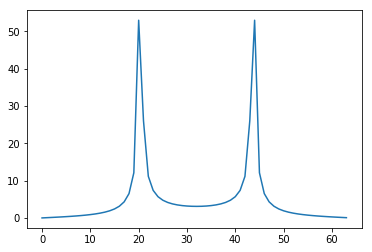

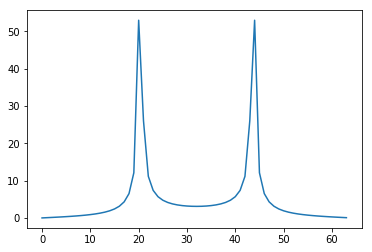

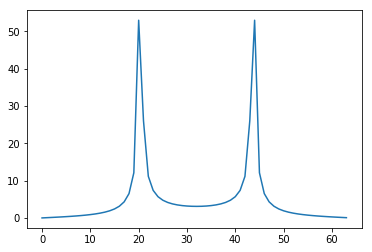

True
True


In [249]:
plt.plot(np.abs(fknp));plt.show()
plt.plot(np.abs(fk));plt.show()
plt.plot(np.abs(fktst));plt.show()

print (np.allclose(fknp,fktst))
print (np.allclose(fk,fktst))